# Introduction
In the previous notebook we have checked for convergence in the squeeze (equilibration) step. We now move on to analyze the production run. The notebook consists of two parts. The first step is to check for the temperature fluctuation and RMSF fluctuation of Cα atoms for all protein chains in our structure. These are sanity checks to make sure the additional electric field is not causing erratic behaviors in our system. The second step is to quantify the shift of net dipole moments of the protein chains due to the different phases of the EF pulses. This provides evidence of how the field could cause subtle perturbation of protein structure that may be of experimental interest.

# Step 1. Temperature and RMSF checks

Since we have deleted all the intermediate trajectories during the production run with `thz_continuous.sh`, we will now run `terahertz_pulse_run.sh` from the previous step to actually produce these trajectories again for analysis. Note that running for 1ns (100 pulse cycles) should be sufficient for our purpose here. And we will just do this for replicate 0 (the first one). Running the script `terahertz_pulse_run.sh` takes about ten minutes and will produce `EF_10MV_cm.csv` and `EF_10MV_cm.h5` files in the production run folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mdtraj
import os
from mdtools.utils import *

We will first look at the temperature fluctuation during the production run when the electric field is applied. This is to ensure that the Langevin thermostat works reasonably even if we are now dumping energy to the system via the electric field oscillations. 

300.869964191294 2.719964191294025


Text(0.5, 1.0, 'System temperature fluctuation during NPT run')

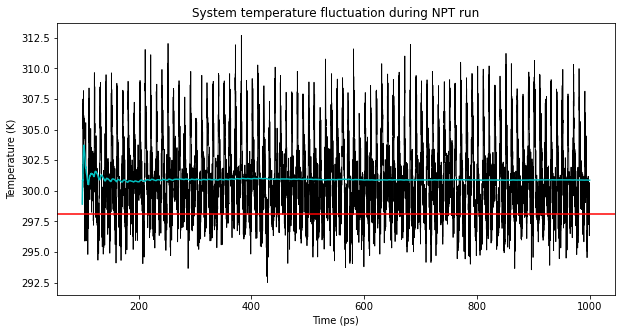

In [2]:
base_dir = '../Production_runs'

df = pd.read_csv(os.path.join(base_dir, 'EF_10MV_cm.csv'))

time_label, temp_label = 'Time (ps)', 'Temperature (K)'
time = df[time_label].to_numpy()[1000:] # discard initial period of 0.1ns
temp = df[temp_label].to_numpy()[1000:]
temp_cum_avg = np.cumsum(temp) / np.arange(1, len(temp)+1)
target_temp = 298.15 # K
print(temp_cum_avg[-1], temp_cum_avg[-1] - target_temp)
plt.figure(figsize=(10,5))
plt.plot(time, temp, color='k', linewidth=0.8)
plt.plot(time, temp_cum_avg, color='c')
plt.axhline(target_temp, color='r')
plt.xlabel(time_label)
plt.ylabel(temp_label)
plt.title('System temperature fluctuation during NPT run')

So we see that the system (cyan) is slightly hotter than the set temperature (red) by 2.7K. With a simple Langevin equation based model we can actually show that a field as strong as 10MV/cm can be expected to give this temperature difference (supplementary notebook to be added later).

Next, we look at root mean square fluctuation (RMSF) values for the Cα atoms of all residues. This give us an idea the set of residues that are relatively floppy in the backbone, so we can omit these when doing structural alignment to improve the result. 

In [3]:
traj = mdtraj.load(os.path.join(base_dir, 'EF_10MV_cm.h5')).remove_solvent()
top = traj.top

In [4]:
rmsf_lst = []
for chain_id in range(4):
    subtraj = traj.atom_slice(top.select(f"chainid=={chain_id} and (name==CA or name==CA1)")) # note: include CA1 for CRO
    subtraj = subtraj.superpose(subtraj, 0)
    rmsf_lst.append(mdtraj.rmsf(subtraj, reference=None))

Text(0.5, 0, 'Residue index')

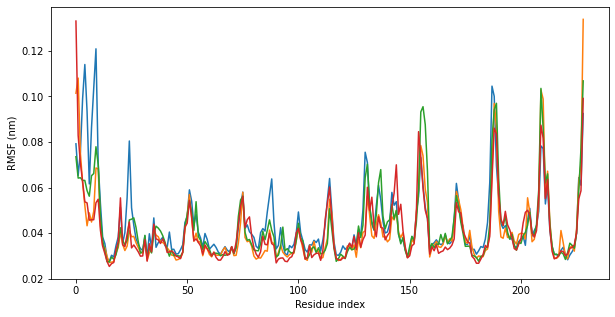

In [5]:
plt.figure(figsize=(10,5))
for chain_id in range(4):
    plt.plot(rmsf_lst[chain_id])

plt.ylabel("RMSF (nm)")
plt.xlabel("Residue index")

We see that indeed there's a small subset of Cα atoms that have higher RMSF values across the four protein chains. Next, we make a histogram to select the threshold for filtering out the most flexible Cα atoms. Note our choice of using a 1ns trajectory length is intended to capture only the fastest motion in protein structure and does not account for certain rotamer flip or conformation change that occurs on hundreds of nanosecond timescale or longer. These slower motions are of interest for electron density map calculation so we *do not* exclude them from structure alignment.


Text(0, 0.5, 'Counts of residues')

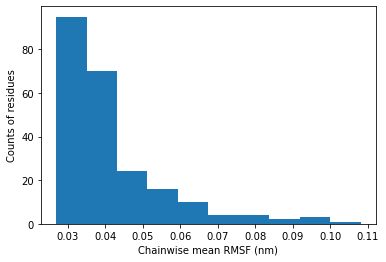

In [6]:
mean_rmsf_across_chains = np.mean(np.array(rmsf_lst), axis=0)
counts, bins_edge, _ = plt.hist(mean_rmsf_across_chains)
plt.xlabel('Chainwise mean RMSF (nm)')
plt.ylabel('Counts of residues')

In [7]:
def expand_selection_from_resid(resid_arr):
    return '(resid ' + ' or resid '.join(str(int(resid)) for resid in resid_arr) + ")"
def expand_selection_from_atom(atom_arr):
    return '(index ' + ' or index '.join(str(int(atom)) for atom in atom_arr) + ")"

In [15]:
rmsf_threshold = 0.06 #nm
n_residues = len(mean_rmsf_across_chains)
assert n_residues == len(list(list(traj.topology.chains)[0].residues))
percentage_over = np.sum(mean_rmsf_across_chains > rmsf_threshold) / n_residues
print(f"Percentage of Ca atoms with RMSF larger than {rmsf_threshold} is {percentage_over:.2f}.")

residues_for_alignment = np.squeeze(np.argwhere(mean_rmsf_across_chains < rmsf_threshold))


# further discard first and last five residues
residues_for_alignment[(residues_for_alignment>4) & (residues_for_alignment<n_residues-5)]
np.save('residues_for_alignment.npy', residues_for_alignment)
atoms_for_alignment = top.select("is_backbone and " + expand_selection_from_resid(residues_for_alignment))
np.save('atoms_for_alignment.npy', atoms_for_alignment)

Percentage of Ca atoms with RMSF larger than 0.06 is 0.10.


The `atoms_for_alignment.npy` file here is used for chainwise structural alignment in the production run script from the previous step. From the filtered list of residues (represented by Cα atoms) we further discard the head and tail of the protein for alignment. Then we expand the atom selection set to include all backbone atoms, not just Cα. Preliminary simulations empirically verified that the above atom selection produce very good result for alignment.

# Step 2. Net dipole moment analysis 

A protein molecule in solution can be considered as a set of electrical charges whose configuration can fluctuate over time. Thus, the electric dipole moment that measures the charge separation in a protein also fluctuates and averages to the permanent dipole of the molecule. The response of the charge configuration to external electric field gives the induced dipole moment and determines the polarizability of the molecule. These quantities can be determined by measuring the effective dielectric constant of the solution and may be of interest in studying certain class of proteins such DNA-binding proteins and ionic channels. Here, we compute net dipole moments from our simulation trajectories simply as an aggregate measure of the response of the protein to the electric field.

First we need to assign partial charges to all atoms in the correctly protonated EGFP structure using our forcefield and store the values to `partial_charges.npy`.

In [7]:
from openmm.app import PDBFile, ForceField
from openff.toolkit.topology import Molecule
import mdtools
forcefield = ForceField('amber/ff14SB.xml', 
                        'amber/tip3p_standard.xml',
                        'amber/tip3p_HFE_multivalent.xml',
                        '../CRO_parametrization/cro.xml')

In [22]:
egfp = PDBFile("../Protein_structure_preparation/lab_fixed.pdb")
mdsystem = mdtools.MDSystem(egfp.topology, 
                            egfp.positions, 
                            forcefield)
partial_charges = mdsystem.getCharges('chainid == 0')
np.save('partial_charges.npy', partial_charges)
print(f"Total number of atoms: {len(partial_charges)}, net charge: {sum(partial_charges):.0f}.")

Total number of atoms: 3621, net charge: -5.


Next, we compute the dipole moment using the formula
$$
\vec{m} = \sum_j q_j \vec{r}_j
$$

where ${q}_j$ and $r_j$ are the partial charge and coordinate (in the center of mass reference frame) of the j-th charged particle in the charge distribution. The python function to do this is imported from mdtools.

In [13]:
asu_ref = mdtraj.load("../Protein_structure_preparation/lab_fixed.pdb").remove_solvent()
asu_ref.save("asu_ref.h5")
unitcell_ref = mdtraj.load("../Production_runs/EF_10MV_cm.h5")[-1].remove_solvent()
unwrap_time_axis(unitcell_ref)
unitcell_ref.save("unitcell_ref.h5")

In [9]:
partial_charges = np.load('partial_charges.npy')
atom_selection = np.load('atoms_for_alignment.npy')
unitcell_ref = mdtraj.load("unitcell_ref.h5")
asu_ref = mdtraj.load("asu_ref.h5")
fname = 'EF_10MV_cm'

traj = mdtraj.load(f'../Production_runs/{fname}.h5')
traj.remove_solvent()
unwrap_time_axis(traj)

align_and_split_by_chain(traj, f'{fname}_unitcell',
                         unitcell_ref=unitcell_ref, asu_ref=asu_ref, 
                         sg=19, chainwise_alignment=False, asu_reversion=False,
                         atom_selection=atom_selection)

In [19]:
ndm_lst = compute_net_dipole_moment(partial_charges, [f'{fname}_unitcell_subtraj_{i}.h5' for i in range(4)])

In [11]:
def plot_net_dipole_moment_clusters(ndm_lst, figsize=(6.4, 4.8*3)):
    idx_to_axis = {0: 'x', 1: 'y', 2: 'z'}
    fig, axs = plt.subplots(3, 1, figsize=figsize)
    for idx, tup in enumerate([(0,1), (0,2), (1,2)]):
        xi, xj = tup
        for i in range(len(ndm_lst)):
            axs[idx].scatter(ndm_lst[i][:,xi], ndm_lst[i][:,xj], alpha=0.2)
            axs[idx].set_xlabel(f'$\mu_{idx_to_axis[xi]} \ (e\cdot nm)$')
            axs[idx].set_ylabel(f'$\mu_{idx_to_axis[xj]} \ (e\cdot nm)$')
        axs[idx].legend([f"Chain {i+1}" for i in range(4)])


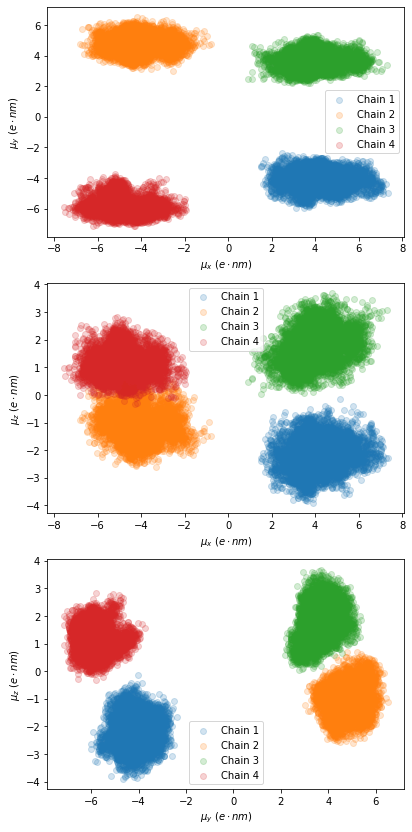

In [20]:
plot_net_dipole_moment_clusters(ndm_lst)

From this we see that while for each chain the net dipole moment vector trajectory form clear clusters, the clusters for symmetrically related protein chains are not strictly symmetrical in the 3D phase space of dipole moment vectors. This is probably due to the artificial correlations between motion of adjacent chains in our 1x1 crystal system and could be eliminated by extensive sampling or averaging over replicates of simulations (which we opt for, for computing the electron density maps).

The above analysis is done by superposing the whole unit cell. We can perform finer analysis by doing chainwise alignment and then look at the clusters of net dipole vectors for each phase and for each chain.

In [13]:
align_and_split_by_chain(traj, f'{fname}_chainwise',
                         unitcell_ref=unitcell_ref, asu_ref=asu_ref, 
                         sg=19, chainwise_alignment=True, asu_reversion=False,
                         atom_selection=atom_selection)


In [21]:
ndm_lst_2 = compute_net_dipole_moment(partial_charges, [f'{fname}_chainwise_subtraj_{i}.h5' for i in range(4)])

In [15]:
def plot_net_dipole_moment_clusters_shift(ndm_lst, figsize=(10,8)):
    idx_to_axis = {0: 'x', 1: 'y', 2: 'z'}
    for xi, xj in [(0,1), (0,2), (1,2)]:
        fig, axs = plt.subplots(2, 2, figsize=(10,8))
        for i, ndm in enumerate(ndm_lst):
            pos_indices = np.concatenate(tuple([np.arange(i,10000,100) for i in range(10)]))
            net_dipole_pos = ndm[pos_indices,:]
            axs[i//2, i%2].scatter(net_dipole_pos[:,xi], net_dipole_pos[:,xj], alpha=0.2)

            neg_indices = np.concatenate(tuple([np.arange(10+i,10000,100) for i in range(10)]))
            net_dipole_neg = ndm[neg_indices,:]
            axs[i//2, i%2].scatter(net_dipole_neg[:,xi], net_dipole_neg[:,xj], alpha=0.2)

            zero_indices = np.concatenate(tuple([np.arange(20+i,10000,100) for i in range(80)]))
            net_dipole_zero = ndm[zero_indices]
            axs[i//2, i%2].scatter(net_dipole_zero[:,xi], net_dipole_zero[:,xj], alpha=0.05)
            axs[i//2, i%2].set_xlabel(f'$\mu_{idx_to_axis[xi]} \ (e\cdot nm)$')
            axs[i//2, i%2].set_ylabel(f'$\mu_{idx_to_axis[xj]} \ (e\cdot nm)$')
            axs[i//2, i%2].legend(["+V","-V","0"])
            axs[i//2, i%2].set_title(f"Chain {i+1}")
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.suptitle('Varying eGFP net dipole moment due to THz pulses')

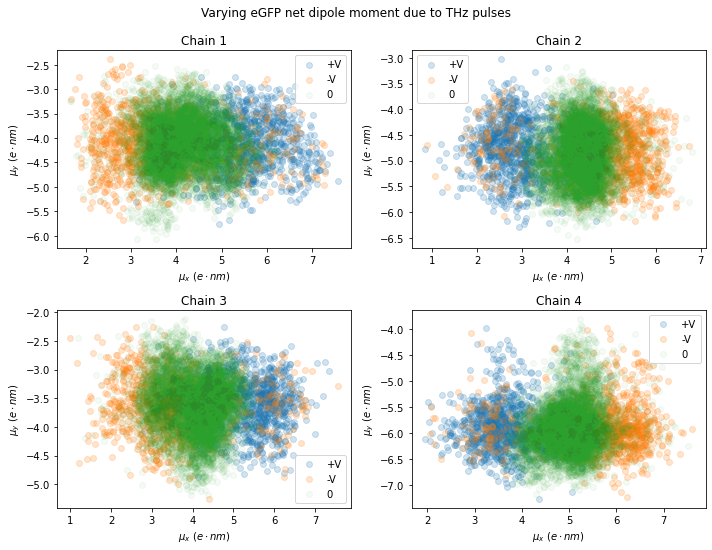

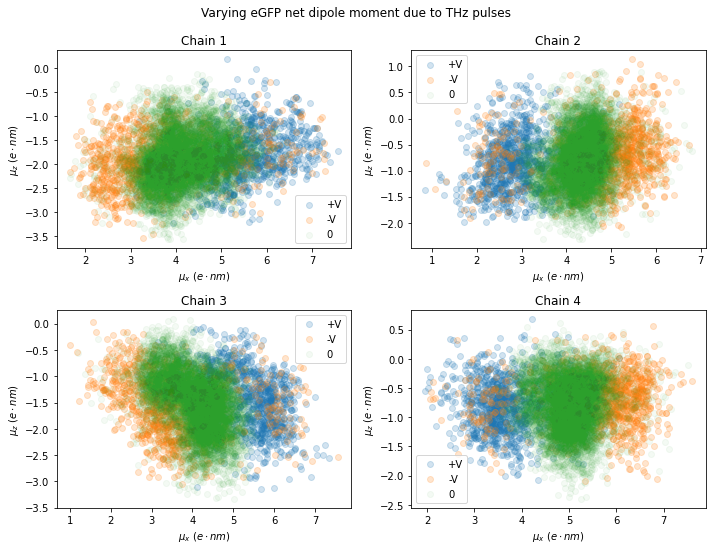

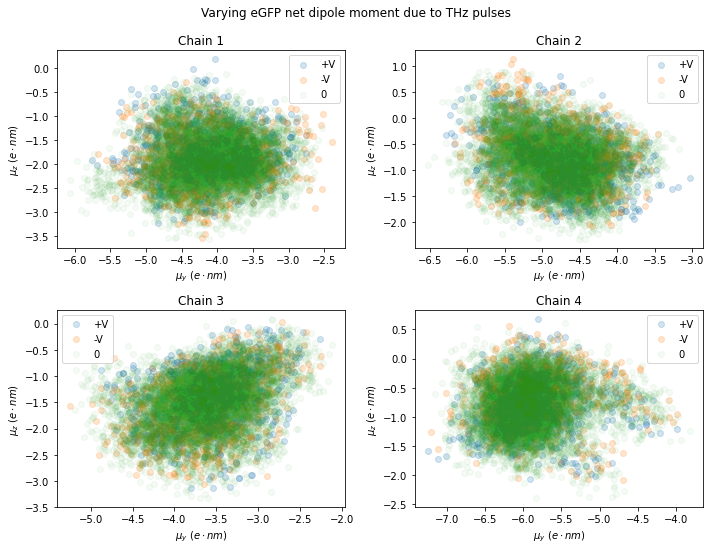

In [22]:
plot_net_dipole_moment_clusters_shift(ndm_lst_2)

We can see there's a pronounced shift in the distribution of net dipole moment vectors along x-direction for all chains, and the shifts are in opposite directions for the +ve and -ve phases relative to the zero field phase. This result is expected because we applied oscillating field in the x-direction. Additionally, we see that the shift pattern are same between chain 1 and 3 and opposite between all other pairs. This also makes sense because chain 1 and 3 in our crystal system are symmetrically related by a rotation by x-axis, which does not change the direction of the net dipole moment vector, whereas for all other pairs we need to rotate by y- or z-axes.


Finally, we can look at the evolution of the net dipole moment vector over a pulse cycle, by averaging over all pulse cycles. This helps to confirm that our simulation setup allows the system to relax after each pulse of just 10ps. Note that the evolution here is does not faithfully represent the actual protein dynamics because we used Langevin thermostat which has a fictional friction term. 

In [17]:
def compute_net_dipole_over_cycle_statistic(ndm, n_steps=100):
    net_dipole_over_cycles = np.stack(tuple([ndm[i*n_steps:(i+1)*n_steps,:] for i in range(len(ndm)//n_steps)]))
    mean_net_dipole_over_cycles = np.mean(net_dipole_over_cycles, axis=0)
    std_net_dipole_over_cycles = np.std(net_dipole_over_cycles, axis=0)
    return mean_net_dipole_over_cycles, std_net_dipole_over_cycles

def plot_net_dipole_moment_evolution(mean_net_dipole_over_cycles, std_net_dipole_over_cycles):
    fig, axs = plt.subplots(3, figsize=(6.4,14.4))
    t = np.arange(0,10,0.1)
    for i, axis in zip(range(3), ['x', 'y', 'z']):
        axs[i].plot(t, mean_net_dipole_over_cycles[:,i], color='k')
        axs[i].fill_between(t, mean_net_dipole_over_cycles[:,i] - std_net_dipole_over_cycles[:,i],
                            mean_net_dipole_over_cycles[:,i] + std_net_dipole_over_cycles[:,i],
                            alpha=0.3)
        axs[i].set_xlabel('Elapsed time per cycle (ps)')
        axs[i].set_ylabel(f'$\mu_{axis} \ (e\cdot nm)$ ')
        axs[i].legend([f'{axis}-axis'])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Evolution of eGFP dipole moment along different axes')


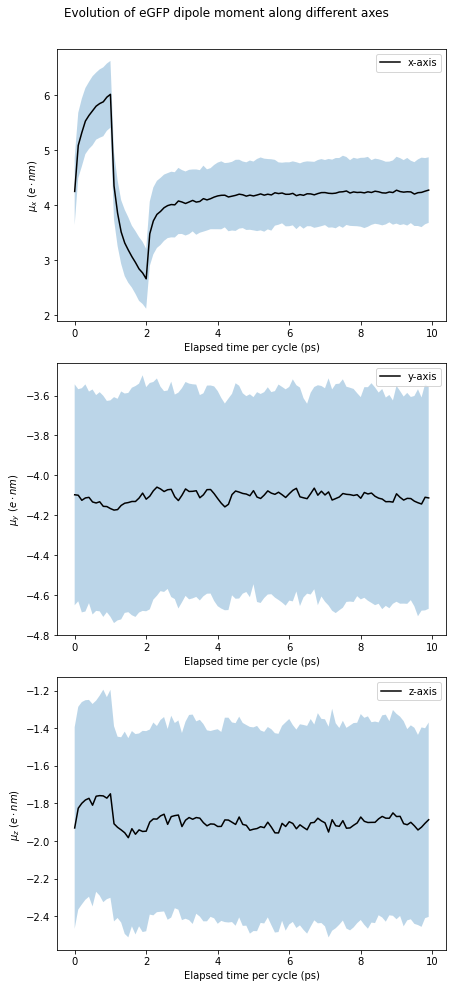

In [23]:
mean_ndm, std_ndm = compute_net_dipole_over_cycle_statistic(ndm_lst_2[0])
plot_net_dipole_moment_evolution(mean_ndm, std_ndm)

As expected, we see clear rising and falling edges of averaged net dipole moment in the x-direction when the field suddenly changes, and we see that the 8ps zero field phase is sufficient for the induced change in dipole moment to decay back to zero, thus validating our setup. In comparison, in the y- and z-directions the induced change in dipole moment is negligible as expected.